In [1]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import pickle as pkl
from itertools import islice
import datetime
import random
import itertools
import glob
import pickle as pkl
import time
import os
import fancyimpute, impyute

# from keras.models import Sequential
# from keras.layers import LSTM, Masking, Dense, RepeatVector, TimeDistributed

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.utils import plot_model

from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

rootPath = '../IMDA/'


Populating the interactive namespace from numpy and matplotlib


/Users/phuw273g/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


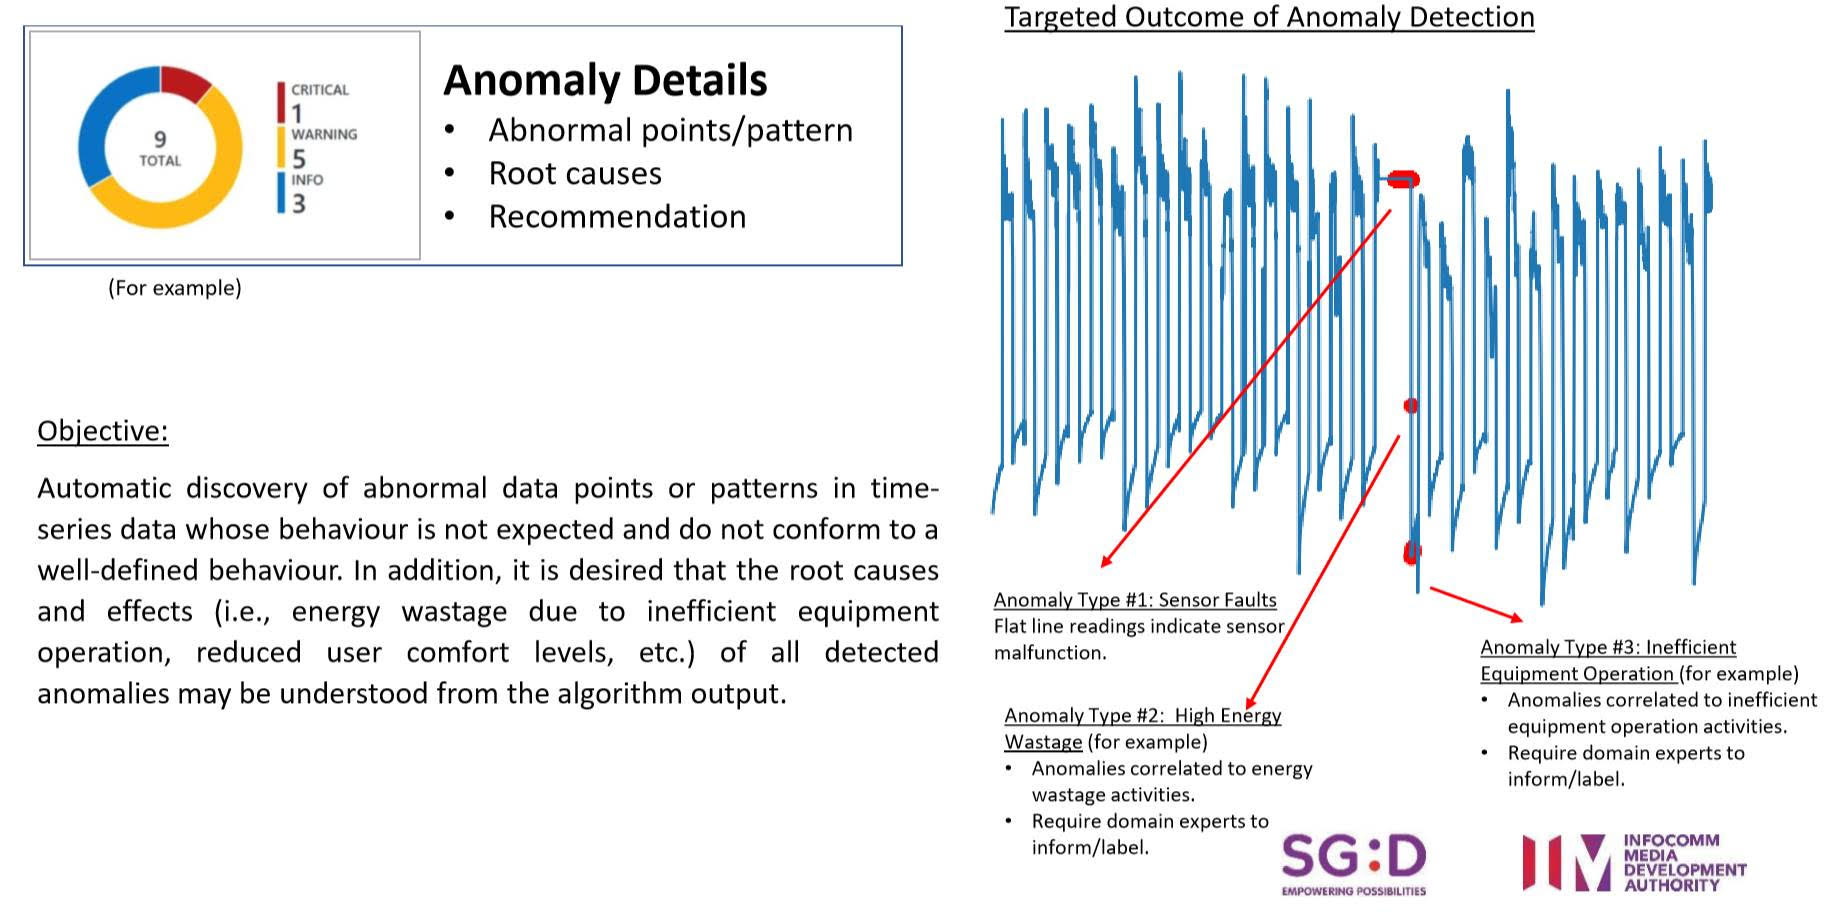

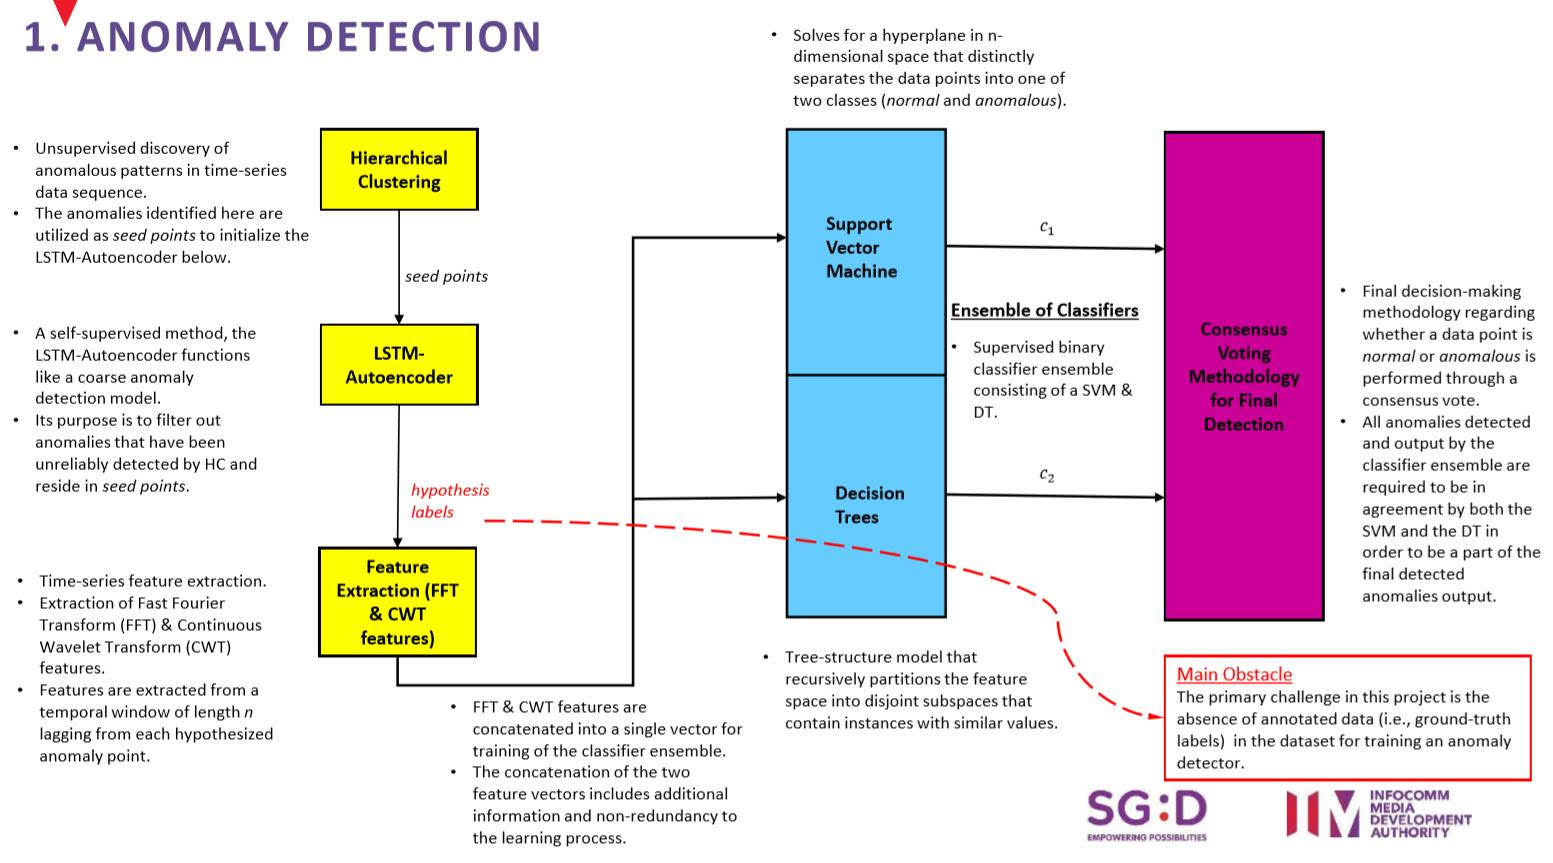

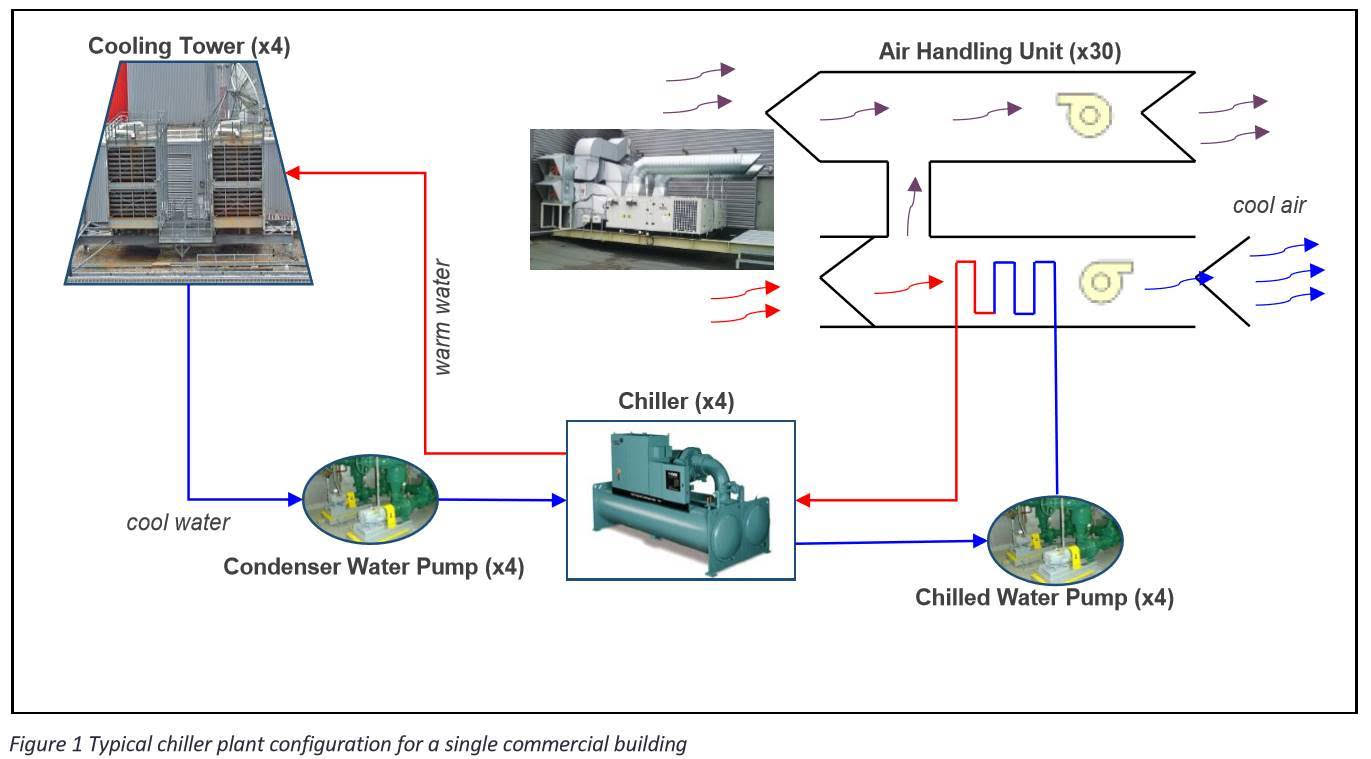
## Columns meaning:
 - CWRT: Condenser Water Return Temperature
 - HLI Entering CHW Temp: High Level Interface Entering (Return) Chilled Water Temperature

__*Anomaly Types*__ <br>
1. sensor fault
2. high energy wastage anomaly
3. inefficient equipment operation anomaly

## Read Data

In [2]:
maincols = ['CWRT_syth', 'HLI Entering CHW Temp']
timecols=['weekday', 'hourminute']
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

#### data_2

In [3]:
data_2 = pd.read_csv(rootPath+'data_2.csv', index_col='Unnamed: 0', date_parser=dateparse)

print(data_2.shape)
print(data_2.dtypes)
print(min(data_2.index), max(data_2.index))
display(data_2.head())


(17719, 13)
Date                                                object
Time                                                object
CWRT_syth                                          float64
HLI Entering CHW Temp                              float64
LABEL_(CWRT_syth)_(wrong_gap)                         bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)             bool
day                                                  int64
weekday                                              int64
hourminute                                           int64
LABEL_(CWRT_syth)_(extreme_value)                     bool
LABEL_(HLI Entering CHW Temp)_(extreme_value)         bool
LABEL_(CWRT_syth_profile)_(outlier)                   bool
LABEL_(HLI Entering CHW Temp_profile)_(outlier)       bool
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),day,weekday,hourminute,LABEL_(CWRT_syth)_(extreme_value),LABEL_(HLI Entering CHW Temp)_(extreme_value),LABEL_(CWRT_syth_profile)_(outlier),LABEL_(HLI Entering CHW Temp_profile)_(outlier)
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,13,7,0,False,False,False,False
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,13,7,5,False,False,False,False
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,13,7,10,False,False,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,13,7,15,False,False,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,13,7,20,False,False,False,False


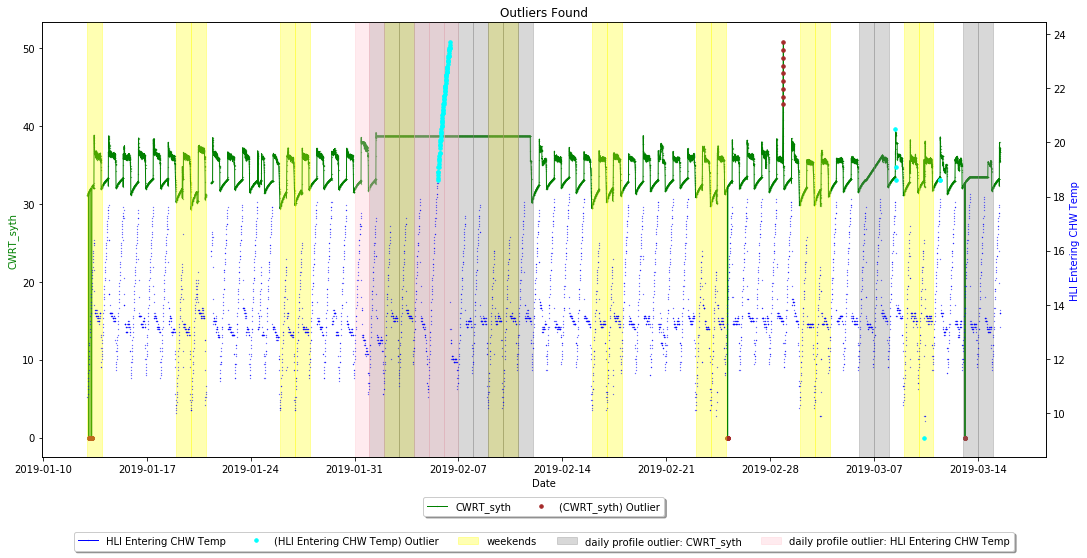

In [4]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2.index, data_2['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2.index, data_2['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1

# daily profile outlier
for col, clr in zip(maincols, ['grey', 'pink']):
    abnormaldays = np.unique(data_2[data_2[
        'LABEL_('+col+'_profile)_(outlier)']].index.date)
    tmp2 = data_2.index.to_frame()
    tmp2['date'] = tmp.index.date
    i = 0
    for dt in abnormaldays:
        alltm_dt = tmp[str(dt)].index
        if i == len(abnormaldays)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color=clr, 
                label='daily profile outlier: '+col)    
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color=clr)  
        i += 1

# plot outliers
sub1 = data_2[data_2['LABEL_(CWRT_syth)_(extreme_value)']].copy()
ax1.plot_date(sub1.index, sub1['CWRT_syth'], 
              c='brown', markersize=7, marker='.', linewidth=1, linestyle='', label='(CWRT_syth) Outlier')
sub2 = data_2[data_2['LABEL_(HLI Entering CHW Temp)_(extreme_value)']].copy()
ax2.plot_date(sub2.index, sub2['HLI Entering CHW Temp'], 
              c='cyan', markersize=7,  marker='.', linewidth=1, linestyle='', label='(HLI Entering CHW Temp) Outlier')      
        
plt.title('Outliers Found')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


In [5]:
data_2_modified_clean = data_2.copy()
data_2_modified_clean.loc[
    data_2_modified_clean[[c for c in list(data_2) if 'label' in c.lower()]].sum(axis=1)>0, 
    maincols] = np.nan

print(data_2_modified_clean.shape)
print(data_2_modified_clean.dtypes)
print(min(data_2_modified_clean.index), max(data_2_modified_clean.index))
display(data_2_modified_clean.head())

(17719, 13)
Date                                                object
Time                                                object
CWRT_syth                                          float64
HLI Entering CHW Temp                              float64
LABEL_(CWRT_syth)_(wrong_gap)                         bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)             bool
day                                                  int64
weekday                                              int64
hourminute                                           int64
LABEL_(CWRT_syth)_(extreme_value)                     bool
LABEL_(HLI Entering CHW Temp)_(extreme_value)         bool
LABEL_(CWRT_syth_profile)_(outlier)                   bool
LABEL_(HLI Entering CHW Temp_profile)_(outlier)       bool
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),day,weekday,hourminute,LABEL_(CWRT_syth)_(extreme_value),LABEL_(HLI Entering CHW Temp)_(extreme_value),LABEL_(CWRT_syth_profile)_(outlier),LABEL_(HLI Entering CHW Temp_profile)_(outlier)
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,13,7,0,False,False,False,False
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,13,7,5,False,False,False,False
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,13,7,10,False,False,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,13,7,15,False,False,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,13,7,20,False,False,False,False


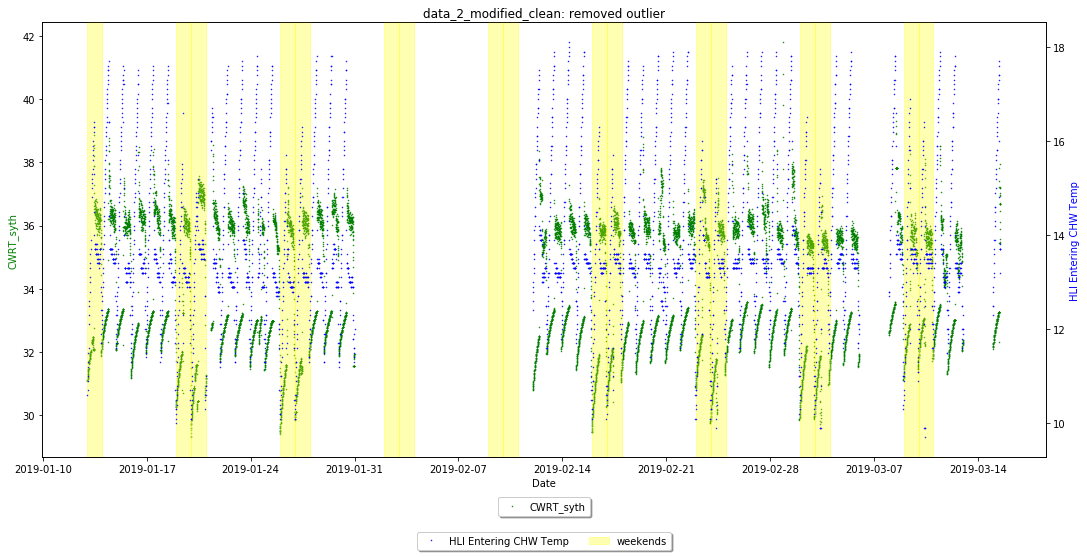

In [6]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_modified_clean.index, data_2_modified_clean['CWRT_syth'], 
              c='g', markersize=1, marker='.', linewidth=1, linestyle='', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_modified_clean.index, data_2_modified_clean['HLI Entering CHW Temp'], 
              c='b', markersize=1,  marker='.', linewidth=1, linestyle='', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2_modified_clean.index.to_frame()
tmp['wkday'] = data_2_modified_clean.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1
    
plt.title('data_2_modified_clean: removed outlier')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


## Data Preparation

In [7]:
def findcorrectgap(pds, pctthreshold):
    gapcnt = pds['gap'].value_counts(ascending=False)
    if gapcnt.iloc[0] / gapcnt.sum() > pctthreshold:
        correct_gap = gapcnt.index[0]    
    else:
        correct_gap = None
    return correct_gap


def findheadandtailnanindex(df_, cols):
    df = df_.copy()
    result = {}
    for col in cols:
        pds = df[col].copy()
        head_ind = list(pds[:pds[pds.notnull()].index[0]].index[:-1])
        tail_ind = list(pds[pds[pds.notnull()].index[-1]:].index[1:])
        result[col] = head_ind + tail_ind
    return result
    
    
# ---------------------------- Imputation -----------------------------
# when the time gap is between (1, 3] times of normal gap, interpolate; 
# when the time gap is between (3, 5] times of normal gap, replace with median;
# else leave it empty

def imputets(df_, medianvalues_ts, correct_timegap, imputecols, timecols):
    df = df_.copy()
    mingap = min(correct_timegap.values())
    # get head and tail nan index
    headtailnanind = findheadandtailnanindex(df, maincols)
    
    for col in imputecols:
        pds = df[col].copy()
        
        tmp = pds.dropna().sort_index(ascending=True).to_frame()
        timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
        tmp['gap'] = pd.Series(list(timediff), index = tmp.index)
        tmp['periods_missed'] = tmp['gap']/mingap

        tmp = tmp[tmp['periods_missed']>1].copy()
        tmp['prev_dt'] = tmp.index.to_series() - tmp['gap'] + mingap

        tmp['dt_missed'] = None
        tmp.loc[tmp['prev_dt'].notna(), 'dt_missed'] = tmp[tmp['prev_dt'].notna()].apply(
                    lambda row: 
                    list(pd.date_range(str(row['prev_dt']), periods=int(row['periods_missed']-1), 
                                       freq=mingap)) 
                    if int(row['periods_missed']-1) > 0 else [row['prev_dt']], 
                    axis=1)

        tgap_morethan5 = tmp[tmp['gap']>5*correct_timegap[col]].copy()
        ts_leave = list(itertools.chain(*list(tgap_morethan5['dt_missed'])))
        df[col+'_leave_empty'] = False
        df.loc[df.index.isin(ts_leave), col+'_leave_empty']=True
        
        tgap_between3n5 = tmp[(tmp['gap']>3*correct_timegap[col]) & 
                              (tmp['gap']<=5*correct_timegap[col])].copy()
        ts_fillmedian = list(itertools.chain(*list(tgap_between3n5['dt_missed'])))
        df[col+'_fill_median'] = False
        df.loc[df.index.isin(ts_fillmedian+headtailnanind[col]), col+'_fill_median']=True

        # fill with median
        sub = df.loc[df[col+'_fill_median']==True, timecols].copy()
        df.loc[df[col+'_fill_median']==True, col] = sub.merge(medianvalues_ts[[col]+timecols], 
          on=timecols, how='left').set_index(sub.index)[col]
        
        # interpolate
        df.loc[:, col] = df.loc[:, col].interpolate(method='polynomial', order=1) 
        # leave blank
        df.loc[df[col+'_leave_empty']==True, col]=np.nan
    return df


In [8]:
# get correct time gaps
correct_timegap = {}
for col in maincols:
    tmp = data_2_modified_clean[col].sort_index(ascending=True).dropna().to_frame()
    timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
    tmp['gap'] = pd.Series(list(timediff), index = tmp.index)
    correct_timegap[col] = findcorrectgap(tmp, 0.7)

correct_timegap    

{'CWRT_syth': Timedelta('0 days 00:05:00'),
 'HLI Entering CHW Temp': Timedelta('0 days 00:15:00')}

In [9]:
# confirm no missing timestamp
pds = data_2_modified_clean.index.to_series()
pds2 = pds.reindex(pd.date_range(start=pds.index[0], end=pds.index[-1], freq=min(correct_timegap.values())))
print(len(np.unique(pds.index)), len(np.unique(pds2.index)))


17719 17719


In [10]:
# medianvalues_ts is used to impute the main dataset
medianvalues_ts = data_2_modified_clean.groupby(timecols)[maincols].median()
medianvalues_ts.reset_index(inplace=True)

allmean = medianvalues_ts.groupby(['hourminute'])[maincols].mean().interpolate(method='polynomial', order=1)

for wkd in np.unique(medianvalues_ts['weekday']):
    # if the first and the last row has missing, then impute with overal mean: allmean
    sub = medianvalues_ts.loc[medianvalues_ts['weekday']==wkd, :].copy()
    sub_stas = sub.describe().T
    tmp_L = list(sub_stas[sub_stas['count'] < len(sub)].index)
    for scol in tmp_L:
        for x in [0, -1]:
            if np.isnan(sub[scol].iloc[x]):
                hourinfo = sub['hourminute'].iloc[x]
                medianvalues_ts.loc[
                    (medianvalues_ts['weekday']==wkd)&(medianvalues_ts.index==sub.index[x]),
                    scol] = allmean.loc[hourinfo, scol]
                
    # for others, impute by interpolation
    medianvalues_ts.loc[medianvalues_ts['weekday']==wkd, :] = medianvalues_ts.loc[
        medianvalues_ts['weekday']==wkd, :].interpolate(method='polynomial', order=1)            

# check and make sure no missing values in medianvalues_ts: !!!!!!!!! what if still missing?
display(medianvalues_ts.describe())
display(medianvalues_ts.head())

,weekday,hourminute,CWRT_syth,HLI Entering CHW Temp
count,2016.000000,2016.000000,2016.000000,2016.000000
mean,4.000000,717.500000,34.010965,13.831749
std,2.000496,415.792824,1.936164,1.587727
min,1.000000,0.000000,29.870000,9.700000
25%,2.000000,358.750000,32.410000,13.100000
50%,4.000000,717.500000,33.270000,13.433334
75%,6.000000,1076.250000,35.911000,14.600000
max,7.000000,1435.000000,38.034000,17.900000


,weekday,hourminute,CWRT_syth,HLI Entering CHW Temp
0,1,0,31.949000,12.400001
1,1,5,31.965000,12.400001
2,1,10,31.973000,12.400001
3,1,15,31.989001,12.500000
4,1,20,32.015001,12.525000


In [11]:
medianvalues_ts.to_csv('medianvalues_ts.csv', index=False)

In [12]:
data_2_modified_clean_impute = imputets(
    data_2_modified_clean, medianvalues_ts, correct_timegap, maincols, timecols)

print(data_2_modified_clean_impute.shape)
print(data_2_modified_clean_impute.dtypes)
print(min(data_2_modified_clean_impute.index), max(data_2_modified_clean_impute.index))
display(data_2_modified_clean_impute.head())

(17719, 17)
Date                                                object
Time                                                object
CWRT_syth                                          float64
HLI Entering CHW Temp                              float64
LABEL_(CWRT_syth)_(wrong_gap)                         bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)             bool
day                                                  int64
weekday                                              int64
hourminute                                           int64
LABEL_(CWRT_syth)_(extreme_value)                     bool
LABEL_(HLI Entering CHW Temp)_(extreme_value)         bool
LABEL_(CWRT_syth_profile)_(outlier)                   bool
LABEL_(HLI Entering CHW Temp_profile)_(outlier)       bool
CWRT_syth_leave_empty                                 bool
CWRT_syth_fill_median                                 bool
HLI Entering CHW Temp_leave_empty                     bool
HLI Entering CHW Temp_fill_median           

,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),day,weekday,hourminute,LABEL_(CWRT_syth)_(extreme_value),LABEL_(HLI Entering CHW Temp)_(extreme_value),LABEL_(CWRT_syth_profile)_(outlier),LABEL_(HLI Entering CHW Temp_profile)_(outlier),CWRT_syth_leave_empty,CWRT_syth_fill_median,HLI Entering CHW Temp_leave_empty,HLI Entering CHW Temp_fill_median
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,11.700000,False,False,13,7,0,False,False,False,False,False,False,False,True
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,11.100000,False,False,13,7,5,False,False,False,False,False,False,False,True
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.600000,False,False,13,7,10,False,False,False,False,False,False,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,10.633334,False,False,13,7,15,False,False,False,False,False,False,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,10.666667,False,False,13,7,20,False,False,False,False,False,False,False,False


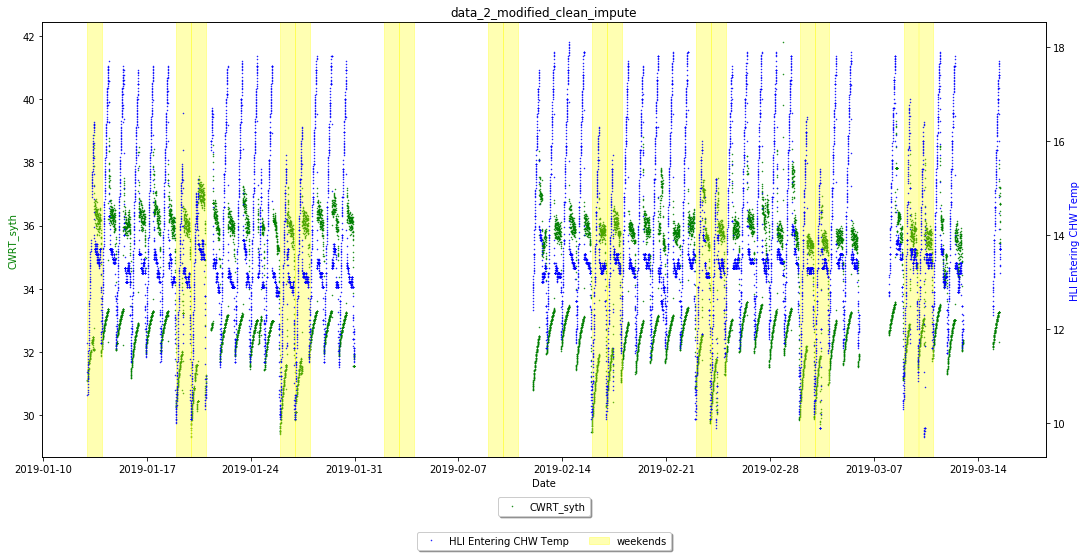

In [13]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_modified_clean_impute.index, data_2_modified_clean_impute['CWRT_syth'], 
              c='g', markersize=1, marker='.', linewidth=1, linestyle='', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_modified_clean_impute.index, data_2_modified_clean_impute['HLI Entering CHW Temp'], 
              c='b', markersize=1,  marker='.', linewidth=1, linestyle='', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2_modified_clean_impute.index.to_frame()
tmp['wkday'] = data_2_modified_clean_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1
    
plt.title('data_2_modified_clean_impute')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


In [14]:
data_2_modified_clean_impute.to_csv('data_2_modified_clean_impute.csv')